**Install Required Libraries**

In [11]:
!pip install fastai
!pip install scikit-learn


**Import Libraries**

In [12]:
import pandas as pd
from fastai.text.all import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as py
import matplotlib.pyplot as plt


**Load and Explore the Dataset**

In [13]:
# Load the dataset
url = "/content/drive/MyDrive/Datasets/Sarcasm_Headlines_Dataset.json"
df = pd.read_json(url, lines=True)


# Explore the dataset
print(df.head())


                                                                                              article_link  \
0                      https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5   
1                 https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365   
2            https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697   
3          https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302   
4  https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb   

                                                                               headline  \
0        former versace store clerk sues over secret 'black code' for minority shoppers   
1  the 'roseanne' revival catches up to our thorny political mood, for better and worse   
2       mom starting to fear son's web series closest thing she wi

**Preprocess the Data**

In [14]:
# Split the dataset
train_df, valid_test_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(valid_test_df, test_size=0.5, random_state=42)

# Define the TextDataLoaders for fastai
dls = TextDataLoaders.from_df(df, text_col='headline', label_col='is_sarcastic', valid_pct=0.1)

# Tokenization and Numericalization
dls.show_batch(max_n=3)


,text,category
0,"xxbos ' 12 years a slave , ' ' captain xxunk , ' ' american xxunk , ' ' wolf of wall street , ' ' blue xxunk , ' ' dallas buyers club , ' ' her , ' ' xxunk , ' ' before midnight , ' and ' xxunk ' all written during same continuing education screenwriting class",1
1,"xxbos with big names like the cure and grimes shining at xxunk toronto , it was the details and even a michigan - born xxunk artist that made it a wonderland",0
2,xxbos roy moore on pedophilia accusers : ' these women are only xxunk me now because xxunk xxunk norms have created an environment in which assault allegations are taken seriously ',1


**Train the AWD_LSTM Model**

ASGD Weight-Dropped LSTM

LSTM: Long Short-Term Memory (LSTM) is a kind of time Recurrent Neural Network (RNN), which is suitable for processing and predicting sequential sequences, especially for natural language processing.

[Source](https://medium.com/ai%C2%B3-theory-practice-business/awd-lstm-6b2744e809c5)

In [15]:
# Create the learner
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

# Train the model
learn.fine_tune(4, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.548247,0.485806,0.777903,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.385140,0.309304,0.874906,00:38
1,0.301406,0.268791,0.879775,00:36
2,0.235750,0.240186,0.896629,00:37
3,0.175264,0.240632,0.900000,00:36


**Evaluate the AWD_LSTM Model**

AWD_LSTM Accuracy: 0.9000


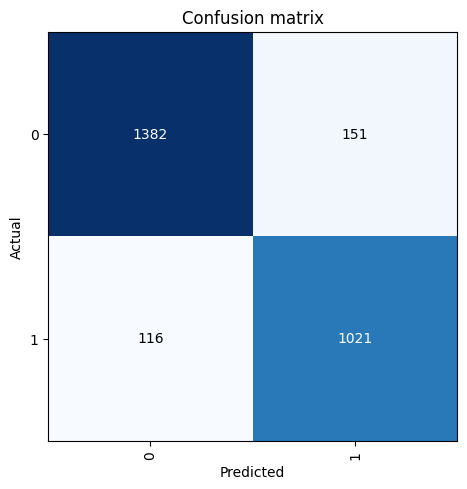

In [18]:
# Evaluate on the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Get accuracy on the validation set
accuracy_awd_lstm = interp.confusion_matrix().trace() / interp.confusion_matrix().sum()
print(f"AWD_LSTM Accuracy: {accuracy_awd_lstm:.4f}")


**Implement Traditional NLP Model (TF-IDF + SVM)**

In [19]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['headline'])
X_valid_tfidf = tfidf_vectorizer.transform(valid_df['headline'])

# SVM Model
svm_model = SVC()
svm_model.fit(X_train_tfidf, train_df['is_sarcastic'])

# Predictions
valid_preds_svm = svm_model.predict(X_valid_tfidf)

# Evaluate SVM Model
accuracy_svm = accuracy_score(valid_df['is_sarcastic'], valid_preds_svm)
print(f"SVM Accuracy: {accuracy_svm}")
print(classification_report(valid_df['is_sarcastic'], valid_preds_svm))


SVM Accuracy: 0.8407388916625063
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2215
           1       0.83      0.81      0.82      1791

    accuracy                           0.84      4006
   macro avg       0.84      0.84      0.84      4006
weighted avg       0.84      0.84      0.84      4006



**TF-IDF Features Distribution:**

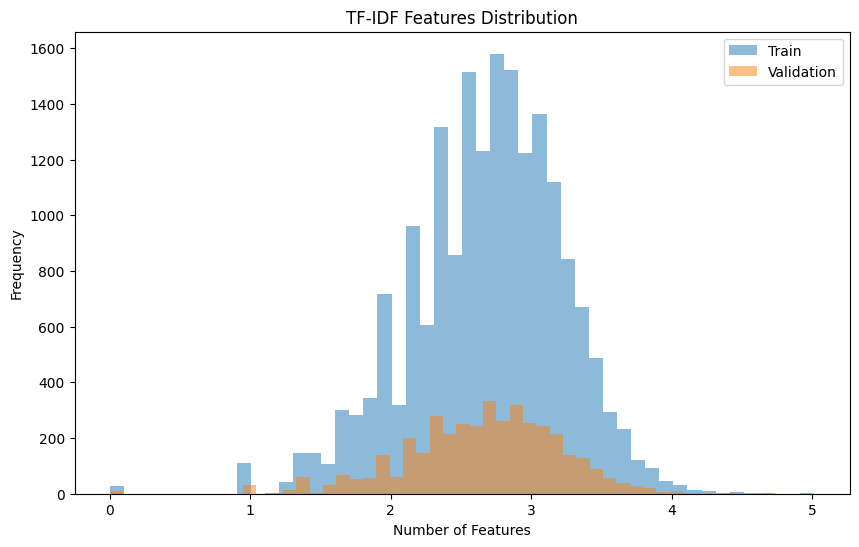

In [20]:
# Visualize TF-IDF features distribution
plt.figure(figsize=(10, 6))
plt.hist(X_train_tfidf.sum(axis=1), bins=50, alpha=0.5, label='Train')
plt.hist(X_valid_tfidf.sum(axis=1), bins=50, alpha=0.5, label='Validation')
plt.title('TF-IDF Features Distribution')
plt.xlabel('Number of Features')
plt.ylabel('Frequency')
plt.legend()
plt.show()
